# Pre-training on Casia webface

## Load the data

In [3]:
import tensorflow as tf, os, cv2, numpy as np
import keras, matplotlib.pyplot as plt

batch_size = 1024
image_size = 112
# dataset = keras.utils.image_dataset_from_directory(
#     os.path.join('data', 'Casia webface', 'archive', 'casia-webface'),
#     labels = 'inferred',
#     label_mode = 'int',
#     batch_size = batch_size,
#     image_size = (image_size, image_size),
#     color_mode = 'rgb'
# )



In [4]:
num_classes = 10572

## Configure the hyperparamters

In [5]:
learning_rate = 0.0001
weight_decay = 0.00001
num_epochs = 500
patch_size = 28
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 6
transformer_units = [
    projection_dim * 2,
    projection_dim
]
transformer_layers = 8
mlp_head_units = [
    2048, 
    1024
]


## Date augmentation for better generalization

In [7]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip('horizontal'),
        keras.layers.RandomRotation(factor = 0.02),
        keras.layers.RandomZoom(height_factor = 0.2, width_factor = 0.2)
    ],
    name = 'data_augmentation'
)

## Patch creation layer

In [8]:
@keras.saving.register_keras_serializable("Patches")
class Patches(keras.layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
    
    def call(self, images):
        input_shape = keras.ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size = self.patch_size)
        patches = keras.ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels
            )
        )

        return patches

    def get_config(self):
        config = super().get_config()
        config.update({'patch_size' : self.patch_size})
        return {**config, 'patch_size' : self.patch_size}

## Demonstrate the patches in action

In [9]:
image = 0
for batch in dataset:
    image = batch[0][10]
    break

image = keras.ops.convert_to_tensor([image])

NameError: name 'dataset' is not defined

In [9]:
patches = Patches(patch_size)(image)

Image size: 112 X 112
Patch size: 28 X 28
Patches per image: 16
Elements per patch: 2352


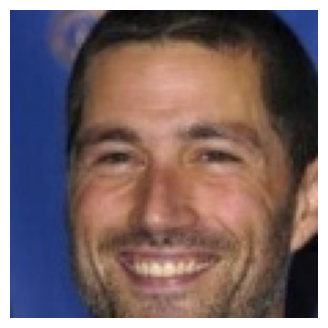

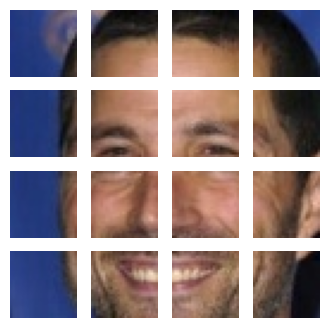

In [10]:
plt.figure(figsize = (4, 4))
plt.imshow(image[0].numpy().astype(np.uint8))
plt.axis('off')


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = keras.ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(keras.ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

## Patch encoding layer

In [10]:
@keras.saving.register_keras_serializable("PatchEncoder")
class PatchEncoder(keras.layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = keras.layers.Dense(units = self.projection_dim)
        self.position_embedding = keras.layers.Embedding(
            input_dim = num_patches,
            output_dim = projection_dim
        )
    
    def call(self, patches):
        positions = keras.ops.expand_dims(
            keras.ops.arange(start = 0, stop = self.num_patches, step = 1), axis = 0
        )
        projected_patches = self.projection(patches)
        encoded = projected_patches + self.position_embedding(positions)
        
        return encoded

    def get_config(self):
        config = super().get_config()
        return {**config, 'num_patches' : self.num_patches, 'projection_dim' : self.projection_dim}


## Build the Vision Transformer

In [11]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = keras.layers.Dense(units, activation=keras.activations.gelu)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
    return x

In [12]:
def create_vit_classifier():
    inputs = keras.Input(shape=(image_size, image_size, 3))
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = keras.layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = keras.layers.Flatten()(representation)
    representation = keras.layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    outputs = keras.layers.Dense(num_classes, activation = keras.activations.softmax)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

## Training

In [15]:
optimizer = keras.optimizers.AdamW(
    learning_rate = learning_rate,
    weight_decay = weight_decay
)

checkpoint_path = os.path.join('data', 'checkpoint', 'ViT 1', 'ViT 1.weights.h5')
model = create_vit_classifier()
model.compile(
    optimizer = optimizer,
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = [
        keras.metrics.SparseCategoricalAccuracy(name = 'accuracy'),
        keras.metrics.SparseTopKCategoricalAccuracy(name = 'top_5_accuracy')
    ]
)

model.load_weights(checkpoint_path)



/home/thoalfeqar/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 280 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Pre-training on LFW

In [14]:
import tensorflow as tf, os, cv2, numpy as np
import keras, matplotlib.pyplot as plt
batch_size = 512
image_size = 112
learning_rate = 0.0001
weight_decay = 0.00001
dataset = keras.utils.image_dataset_from_directory(
    os.path.join('data', 'LFW', 'archive', 'lfw_funneled'),
    labels = 'inferred',
    label_mode = 'int',
    batch_size = batch_size,
    image_size = (image_size, image_size),
    color_mode = 'rgb'
)

Found 13233 files belonging to 5749 classes.


In [15]:
checkpoint_path = os.path.join('data', 'checkpoint', 'ViT 1', 'ViT 1.keras')
model = keras.models.load_model(checkpoint_path)
num_classes = 5749

/home/thoalfeqar/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'patch_encoder_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [16]:
# inputs = model.layers[0].output
# output = model.layers[-2].output
# output = keras.layers.Dense(num_classes, activation = 'softmax')(output)
# model_lfw = keras.models.Model(inputs = inputs, outputs = output)
# model_lfw.compile(
#     optimizer = keras.optimizers.AdamW
#     (
#     learning_rate = learning_rate,
#     weight_decay = weight_decay
#     ),
#     loss = keras.losses.SparseCategoricalCrossentropy(),
#     metrics = [
#         keras.metrics.SparseCategoricalAccuracy(name = 'accuracy'),
#         keras.metrics.SparseTopKCategoricalAccuracy(name = 'top-5-accuracy')
#     ]
# )

model_lfw = keras.models.load_model(os.path.join('data', 'checkpoint', 'ViT 2', 'ViT 2.keras'))

In [16]:
checkpoint = keras.callbacks.ModelCheckpoint(
    os.path.join('data', 'checkpoint', 'ViT 2', 'ViT 2.keras'),
    monitor = 'accuracy',
    save_best_only = True
)

learning_rate_scheduler = keras.callbacks.ReduceLROnPlateau('accuracy')
model_lfw.fit(dataset, batch_size = batch_size, epochs = 200, callbacks = [checkpoint, learning_rate_scheduler])

Epoch 1/200


W0000 00:00:1730642685.184126    4816 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730642685.205056    4816 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730642685.261936    4816 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730642685.325466    4816 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730642685.340729    4816 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730642685.354835    4816 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730642685.373530    4816 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730642685.390875    4816 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730642685.427948    4816 gp

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9289 - loss: 0.2987 - top-5-accuracy: 0.9908

W0000 00:00:1730642690.106356    4812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730642690.122783    4812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730642690.169054    4812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730642690.221235    4812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730642690.232683    4812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730642690.244098    4812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730642690.259370    4812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730642690.275348    4812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730642690.306629    4812 gp

26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 200ms/step - accuracy: 0.9291 - loss: 0.2980 - top-5-accuracy: 0.9909 - learning_rate: 1.0000e-04
Epoch 2/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9270 - loss: 0.2994 - top-5-accuracy: 0.9900 - learning_rate: 1.0000e-04
Epoch 3/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9317 - loss: 0.2910 - top-5-accuracy: 0.9900 - learning_rate: 1.0000e-04
Epoch 4/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9303 - loss: 0.2913 - top-5-accuracy: 0.9904 - learning_rate: 1.0000e-04
Epoch 5/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9281 - loss: 0.3070 - top-5-accuracy: 0.9887 - learning_rate: 1.0000e-04
Epoch 6/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9294 - loss: 0.2970 - top-5-accuracy: 0.9897 - learning_rate: 1.0000e-04
Epoch 7/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9294 - loss: 0.2999 - top-5-accuracy: 0.9892 - learning_rate: 1.0000e-04
Epoch 8/200
26/26 ━━━━━━━━━━━━━

26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 454ms/step - accuracy: 0.9996 - loss: 0.0130 - top-5-accuracy: 1.0000


[0.013078180141746998, 0.9992443323135376, 1.0]